In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model, save_model
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

In [3]:
usernames = ["JustinTrudeau","ElizabethMay","AndrewScheer","MaximeBernier","theJagmeetSingh"]
tweet_frames = []
retweet_frames = []
for username in usernames:
    tweet_frame = pd.read_csv("../data/{}_data.csv".format(username))
    retweet_frame = pd.read_csv("../data/{}_retweets.csv".format(username))
    tweet_frames.append(tweet_frame)
    retweet_frames.append(retweet_frame)
tweet_df = pd.concat(tweet_frames,sort=False)  
retweet_df = pd.concat(retweet_frames,sort=False)
print(tweet_df.shape,retweet_df.shape)
print(tweet_df.columns,retweet_df.columns)
print(len(retweet_df["original_author"].unique()))

(4416, 13) (67491, 8)
Index(['id', 'type', 'created_at', 'source', 'original_text', 'clean_text',
       'favorite_count', 'retweet_count', 'hashtags', 'mentions',
       'original_author', 'lda_cluster', 'to_date'],
      dtype='object') Index(['original_tweet_id', 'retweet_id', 'type', 'created_at', 'source',
       'favorite_count', 'retweet_count', 'original_author'],
      dtype='object')
23198


In [4]:
merged_df = pd.merge(left=retweet_df,right=tweet_df, how='inner', left_on='original_tweet_id', right_on='id')
merged_df.head()

,original_tweet_id,retweet_id,type_x,created_at_x,source_x,favorite_count_x,retweet_count_x,original_author_x,id,type_y,...,source_y,original_text,clean_text,favorite_count_y,retweet_count_y,hashtags,mentions,original_author_y,lda_cluster,to_date
0,1186063209381486593,1188837840680964099,retweet,Mon Oct 28 15:20:03 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",0,3283,roguechimp99,1186063209381486593,tweet,...,"<a href=""https://studio.twitter.com"" rel=""nofo...","Andrew Scheer is against gay marriage, against...",andrew scheer gay marriage woman right choose ...,9289,3216,ChooseForward,NaN,JustinTrudeau,1,NaN
1,1186063209381486593,1188576827108757504,retweet,Sun Oct 27 22:02:52 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",0,3283,SteveScho54,1186063209381486593,tweet,...,"<a href=""https://studio.twitter.com"" rel=""nofo...","Andrew Scheer is against gay marriage, against...",andrew scheer gay marriage woman right choose ...,9289,3216,ChooseForward,NaN,JustinTrudeau,1,NaN
2,1186063209381486593,1188027813716209664,retweet,Sat Oct 26 09:41:17 +0000 2019,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0,3283,Pari95751293,1186063209381486593,tweet,...,"<a href=""https://studio.twitter.com"" rel=""nofo...","Andrew Scheer is against gay marriage, against...",andrew scheer gay marriage woman right choose ...,9289,3216,ChooseForward,NaN,JustinTrudeau,1,NaN
3,1186063209381486593,1187659106854805504,retweet,Fri Oct 25 09:16:11 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",0,3283,MeralJade,1186063209381486593,tweet,...,"<a href=""https://studio.twitter.com"" rel=""nofo...","Andrew Scheer is against gay marriage, against...",andrew scheer gay marriage woman right choose ...,9289,3216,ChooseForward,NaN,JustinTrudeau,1,NaN
4,1186063209381486593,1187592355945299968,retweet,Fri Oct 25 04:50:56 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",0,3283,IpsumMater,1186063209381486593,tweet,...,"<a href=""https://studio.twitter.com"" rel=""nofo...","Andrew Scheer is against gay marriage, against...",andrew scheer gay marriage woman right choose ...,9289,3216,ChooseForward,NaN,JustinTrudeau,1,NaN


In [5]:
merged_df = merged_df.drop(['type_y','type_x', 'created_at_x', 'source_x',
       'favorite_count_x', 'retweet_count_x', 'id',
       'type_y', 'created_at_y', 'source_y', 'original_text', 'clean_text',
       'favorite_count_y', 'retweet_count_y', 'hashtags', 'mentions','to_date'],axis=1)
merged_df.columns = ['id', 'retweet_id','retweet_author','tweet_author','lda_cluster']
print(merged_df.columns,merged_df.shape)
merged_df.head()

Index(['id', 'retweet_id', 'retweet_author', 'tweet_author', 'lda_cluster'], dtype='object') (65897, 5)


,id,retweet_id,retweet_author,tweet_author,lda_cluster
0,1186063209381486593,1188837840680964099,roguechimp99,JustinTrudeau,1
1,1186063209381486593,1188576827108757504,SteveScho54,JustinTrudeau,1
2,1186063209381486593,1188027813716209664,Pari95751293,JustinTrudeau,1
3,1186063209381486593,1187659106854805504,MeralJade,JustinTrudeau,1
4,1186063209381486593,1187592355945299968,IpsumMater,JustinTrudeau,1


In [6]:
merged_df = merged_df.groupby(['retweet_author', 'tweet_author']).size().reset_index(name='count')
merged_df = merged_df.sort_values(by=['retweet_author','tweet_author'])
# How many users tweeted more a topic more than once.
print(len(merged_df[merged_df["count"] > 1]))
merged_df.head()

7530


,retweet_author,tweet_author,count
0,000l0lll000l,JustinTrudeau,1
1,0014966f0dea434,JustinTrudeau,3
2,001_balwinder,theJagmeetSingh,2
3,007Drea,theJagmeetSingh,2
4,00kvi,MaximeBernier,1


In [7]:
# Pivot the data so that eac row is a user, and columns [1:] repreesnt the number of times a user tweeted that topic.
aggregated = merged_df.pivot(index='retweet_author', columns='tweet_author', values='count')
aggregated.columns.name = None
aggregated = aggregated.reset_index()
aggregated = aggregated[:].fillna(0)
target_labels = list(aggregated.columns)[1:]
print(target_labels)
aggregated.head()

['AndrewScheer', 'ElizabethMay', 'JustinTrudeau', 'MaximeBernier', 'theJagmeetSingh']


,retweet_author,AndrewScheer,ElizabethMay,JustinTrudeau,MaximeBernier,theJagmeetSingh
0,000l0lll000l,0.0,0.0,1.0,0.0,0.0
1,0014966f0dea434,0.0,0.0,3.0,0.0,0.0
2,001_balwinder,0.0,0.0,0.0,0.0,2.0
3,007Drea,0.0,0.0,0.0,0.0,2.0
4,00kvi,0.0,0.0,0.0,1.0,0.0


In [8]:
def to_training_data(aRow):
    aRow = list(aRow)
    author = aRow[0]
    clusters = aRow[1:]
    columns = [str(i) for i in range(len(clusters))]
    columns.append("target")
    frames = []
    if max(clusters) <= 1:
        for index,val in enumerate(clusters):
            if val > 0:
                new_row = clusters.copy()
                # Obfuscate one of the vals
                new_row[index] -=1
                # This last index is the target
                new_row.append(index)
                frames.append(new_row)
    else: # we want to encourage clustering based on what a user does. Therefore if they've already shown a disposition to retweeting a certain leader. We only obfuscate that leader
        max_ind = np.argmax(clusters)
        new_row = clusters.copy()
        new_row[max_ind] -= 1
        new_row.append(max_ind)
        frames.append(new_row)
    return pd.DataFrame(frames,columns=columns)

In [9]:
aggregate_df = list(aggregated.apply(lambda row : to_training_data(row),axis=1))
aggregate_df = pd.concat(aggregate_df)
aggregate_df.columns = target_labels+["target"]
print(aggregate_df.head())
aggregate_numpy = aggregate_df.to_numpy()

AndrewScheer  ElizabethMay  JustinTrudeau  MaximeBernier  theJagmeetSingh  \
0           0.0           0.0            0.0            0.0              0.0   
0           0.0           0.0            2.0            0.0              0.0   
0           0.0           0.0            0.0            0.0              1.0   
0           0.0           0.0            0.0            0.0              1.0   
0           0.0           0.0            0.0            0.0              0.0   

   target  
0       2  
0       2  
0       4  
0       4  
0       3  


In [10]:
msk = np.random.rand(len(aggregate_numpy)) < 0.8
training_data = aggregate_numpy[msk]
testing_data = aggregate_numpy[~msk]
print(training_data.shape,testing_data.shape)

(18260, 6) (4677, 6)


In [11]:
x_training, y_training = training_data[:,:-1],training_data[:,-1] 
x_testing, y_testing = testing_data[:,:-1],testing_data[:,-1] 
num_labels = len(np.unique(y_training))
#One hot encode
y_training_encoded = np.zeros((y_training.size, num_labels))
y_training_encoded[np.arange(y_training.size), y_training.astype(int)] = 1
y_testing_encoded = np.zeros((y_testing.size, num_labels))
y_testing_encoded[np.arange(y_testing.size), y_testing.astype(int)] = 1
print(x_training.shape,y_training_encoded.shape)

(18260, 5) (18260, 5)


In [12]:
# Since class 3 dominates the rest we are going to give different penalities for missclassifcation.
class_weights = compute_class_weight("balanced", np.unique(aggregate_numpy[:,-1]),aggregate_numpy[:,-1])
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 0.7424178669687652, 1: 3.49117199391172, 2: 0.5847546207775653, 3: 3.1313310580204776, 4: 0.7478643625692859}


In [84]:
print("--- Initializing Model ---")
# opt = keras.optimizers.SGD(lr=0.01,decay=1e-6)
opt = keras.optimizers.Adam()
model = Sequential()
model.add(Dense(num_labels, activation="relu"))
model.add(Dense(20, activation="relu"))
# model.add(Dropout(0.3))
model.add(Dense(15, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(num_labels, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

--- Initializing Model ---


In [85]:
epochs = 20
batch_size = 64
callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001,verbose=1)
model.fit(x_training,y_training_encoded, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[callback],class_weight=d_class_weights,verbose=1)
# history = model.fit(x_training,y_training_encoded, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[callback],verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 16434 samples, validate on 1826 samples
Epoch 1/20
16434/16434 [==============================] - 1s 87us/sample - loss: 0.5807 - accuracy: 0.7878 - val_loss: 0.4814 - val_accuracy: 0.8139
Epoch 2/20
16434/16434 [==============================] - 1s 44us/sample - loss: 0.4349 - accuracy: 0.8309 - val_loss: 0.4216 - val_accuracy: 0.8353
Epoch 3/20
16434/16434 [==============================] - 1s 44us/sample - loss: 0.4082 - accuracy: 0.8399 - val_loss: 0.4058 - val_accuracy: 0.8396
Epoch 4/20
16434/16434 [==============================] - 1s 39us/sample - loss: 0.3982 - accuracy: 0.8434 - val_loss: 0.3979 - val_accuracy: 0.8393
Epoch 5/20
16434/16434 [==============================] - 1s 39us/sample - loss: 0.3900 - accuracy: 0.8436 - val_loss: 0.3921 - val_accuracy: 0.8395
Epoch 6/20
16434/16434 [==============================] - 1s 39us/sample - loss: 0.3818 - accuracy: 0.8446 - val_loss: 0.3834 - val_accuracy: 0.8428
Epoch 7

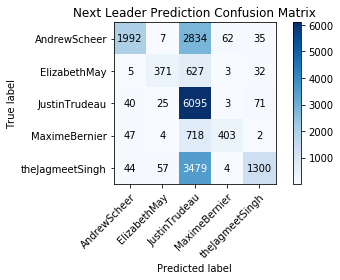

In [87]:
predictions = model.predict_classes(x_training)
classes = sorted(list(aggregate_df.columns)[:-1])
cm = confusion_matrix(y_training, predictions)
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
"""
title = 'Next Leader Prediction Confusion Matrix'
    
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
fmt = 'd'
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig("../visualizations/neural_net/next_leader_CM.png")

In [93]:
save_model(model,"dense_next_leader.h5")

In [92]:
test = np.array([0,0,1,0,1]).reshape((1,5))
print(model.predict(test))

[[0.02029115 0.06002866 0.42597854 0.0101888  0.16531159]]
